<a href="https://colab.research.google.com/github/Korniev/Machine-Learning-projects/blob/main/image_classification_tiny_imagenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

In [4]:
# upload the file to Google Colab
from google.colab import files
uploaded = files.upload()

# List the uploaded files to verify
for filename in uploaded.keys():
    print(f'Uploaded file: {filename}')

# Extract the uploaded file
import zipfile
import os

# Assuming the uploaded file is named 'archive.zip'
zip_path = '/content/archive.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')

# Verify the extracted files
!ls /content/tiny-imagenet-200

Saving archive.zip to archive.zip
Uploaded file: archive.zip
test  train  val  wnids.txt  words.txt


In [5]:
import os
import shutil

val_dir = '/content/tiny-imagenet-200/val'
val_images_dir = os.path.join(val_dir, 'images')
val_annotations_file = os.path.join(val_dir, 'val_annotations.txt')

# Create subdirectories for each class
with open(val_annotations_file, 'r') as f:
    for line in f.readlines():
        parts = line.strip().split('\t')
        image_name = parts[0]
        class_name = parts[1]

        class_dir = os.path.join(val_dir, class_name)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        source = os.path.join(val_images_dir, image_name)
        destination = os.path.join(class_dir, image_name)
        shutil.move(source, destination)

# Remove the now-empty images directory
shutil.rmtree(val_images_dir)


In [6]:


# Define paths
train_dir = './tiny-imagenet-200/train'
val_dir = './tiny-imagenet-200/val'

# Define image data generators with enhanced data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)


Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.


In [11]:
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(200, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Fine-tune the entire model
for layer in base_model.layers[-50:]:  # Unfreeze the last 50 layers
    layer.trainable = True

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define a learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

lr_scheduler = LearningRateScheduler(scheduler)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.000001)

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, lr_scheduler]
)

Epoch 1/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 346s 89ms/step - accuracy: 0.1076 - loss: 15.3802 - val_accuracy: 0.3357 - val_loss: 6.7644 - learning_rate: 1.0000e-04
Epoch 2/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 257s 78ms/step - accuracy: 0.3037 - loss: 5.9559 - val_accuracy: 0.3795 - val_loss: 4.0661 - learning_rate: 1.0000e-04
Epoch 3/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 244s 78ms/step - accuracy: 0.3605 - loss: 3.8256 - val_accuracy: 0.3865 - val_loss: 3.4802 - learning_rate: 1.0000e-04
Epoch 4/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 261s 78ms/step - accuracy: 0.3869 - loss: 3.2349 - val_accuracy: 0.4085 - val_loss: 3.1763 - learning_rate: 1.0000e-04
Epoch 5/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 246s 79ms/step - accuracy: 0.4190 - loss: 2.9556 - val_accuracy: 0.4357 - val_loss: 3.0314 - learning_rate: 1.0000e-04
Epoch 6/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 280s 89ms/step - accuracy: 0.4450 - loss: 2.7877 - val_accuracy: 0.3871 - val_loss: 3.2879 - learning_rate: 1.0000e-04
Epoch 7/50
3125/3125 ━━━━━━━━━━━━

In [12]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Accuracy: {val_accuracy}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5323 - loss: 2.2573
Validation Accuracy: 0.5321000218391418


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predictions: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]]
Predicted class index: 44
Predicted class label: n02279972


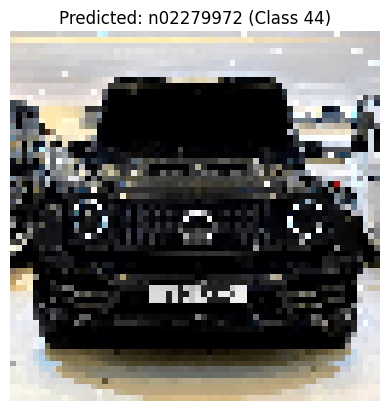

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model

# Define a function to load, preprocess, and predict an image
def predict_and_visualize(image_path, model, class_indices):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(64, 64))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Make predictions
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]

    # Decode the prediction
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class_label = class_labels[predicted_class_index]

    # Print prediction probabilities for debugging
    print(f"Predictions: {predictions}")
    print(f"Predicted class index: {predicted_class_index}")
    print(f"Predicted class label: {predicted_class_label}")

    # Visualize the result
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class_label} (Class {predicted_class_index})')
    plt.axis('off')
    plt.show()

# Assume 'class_indices' is a dictionary mapping class names to their index
class_indices = train_generator.class_indices

# Test the function with an example image
predict_and_visualize('/content/ind3.webp', model, class_indices)
